# Task 3 - Quanvolutional Neural Networks

In [ ]:
# Installations
!pip install pennylane
!pip install wget

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=090b7ad9ba9f5e8dff006e02e18885c24dd9b89888ebe300bc7aa91ca813717a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Imports, path defs and data fetch

In [ ]:
# Imports
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import wget
from pathlib import Path

In [ ]:
# Configs
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [ ]:
# Data Fetch
SAVE_PATH = Path.cwd() / "Quanvolution" # Data saving folder

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Important definitions

In [ ]:
# Creating device and randomly initializing parameters
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

In [ ]:
# Defining Embedding circuit
@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [ ]:
# Defining Quanvolutional Layer
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum preprocessing of dataset

In [ ]:
# Preprocessing and saving
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:

Quantum pre-processing of test images:


TypeError: unsupported operand type(s) for +: 'PosixPath' and 'str'

## Visualizing preprocessing effect

In [ ]:
# Plotting preprocessed images
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Defining hybrid quantum-classical model

In [ ]:
# Defining and compiling Classical MLP with Adam optimizer and Cross-Entropy Loss
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training the model

In [ ]:
# Model training - Quantum Hybrid
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 90ms/step - accuracy: 0.1000 - loss: 2.8122 - val_accuracy: 0.2000 - val_loss: 2.3816
Epoch 2/30
13/13 - 0s - 20ms/step - accuracy: 0.2400 - loss: 2.0051 - val_accuracy: 0.3000 - val_loss: 2.1833
Epoch 3/30
13/13 - 0s - 11ms/step - accuracy: 0.5200 - loss: 1.6976 - val_accuracy: 0.3667 - val_loss: 1.9893
Epoch 4/30
13/13 - 0s - 11ms/step - accuracy: 0.8000 - loss: 1.3825 - val_accuracy: 0.3667 - val_loss: 1.8380
Epoch 5/30
13/13 - 0s - 6ms/step - accuracy: 0.8800 - loss: 1.1399 - val_accuracy: 0.4000 - val_loss: 1.7296
Epoch 6/30
13/13 - 0s - 10ms/step - accuracy: 0.9600 - loss: 0.9456 - val_accuracy: 0.5667 - val_loss: 1.6382
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.7906 - val_accuracy: 0.6000 - val_loss: 1.5599
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9600 - loss: 0.6689 - val_accuracy: 0.6333 - val_loss: 1.4977
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.5698 - val_accuracy: 0.6333 - val_loss: 1.4455
Epoch 10/30
13

In [ ]:
# Model training - pure classical
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 2s - 128ms/step - accuracy: 0.1200 - loss: 2.3560 - val_accuracy: 0.2000 - val_loss: 2.1265
Epoch 2/30
13/13 - 0s - 9ms/step - accuracy: 0.4800 - loss: 1.9388 - val_accuracy: 0.4000 - val_loss: 2.0097
Epoch 3/30
13/13 - 0s - 8ms/step - accuracy: 0.6000 - loss: 1.6543 - val_accuracy: 0.3667 - val_loss: 1.8965
Epoch 4/30
13/13 - 0s - 7ms/step - accuracy: 0.7600 - loss: 1.4216 - val_accuracy: 0.4333 - val_loss: 1.7859
Epoch 5/30
13/13 - 0s - 10ms/step - accuracy: 0.8400 - loss: 1.2267 - val_accuracy: 0.5000 - val_loss: 1.6846
Epoch 6/30
13/13 - 0s - 11ms/step - accuracy: 0.9000 - loss: 1.0636 - val_accuracy: 0.4667 - val_loss: 1.5964
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.9000 - loss: 0.9277 - val_accuracy: 0.5333 - val_loss: 1.5216
Epoch 8/30
13/13 - 0s - 10ms/step - accuracy: 0.9400 - loss: 0.8143 - val_accuracy: 0.5000 - val_loss: 1.4585
Epoch 9/30
13/13 - 0s - 6ms/step - accuracy: 0.9400 - loss: 0.7194 - val_accuracy: 0.5000 - val_loss: 1.4048
Epoch 10/30
13

## Results

<ipython-input-20-388dde8736c9>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


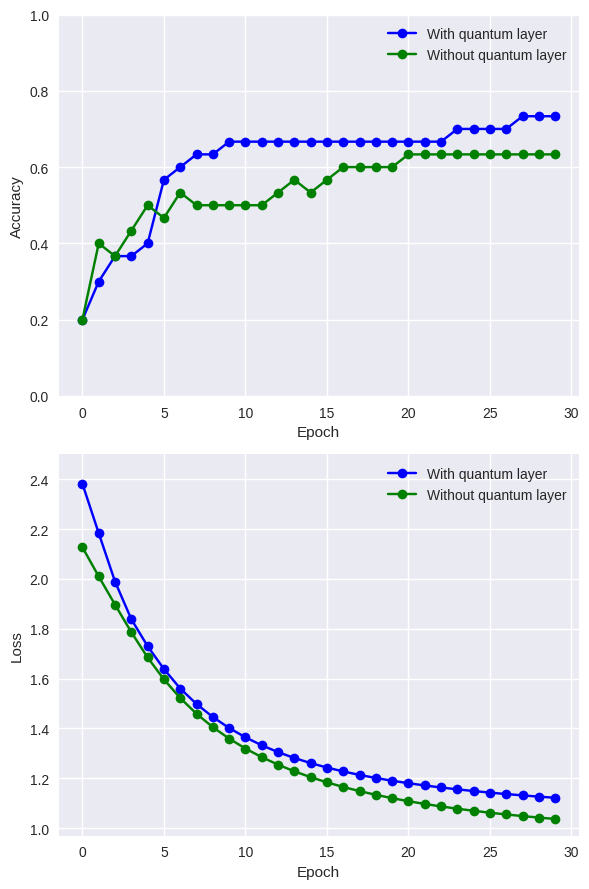

In [ ]:
# Plotting test accuracy and test loss
import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()